<div style="background: #efffed;
            border: 1px solid grey;
            margin: 8px 0 8px 0;
            text-align: center;
            padding: 8px; ">
    <i class="fa-play fa" 
       style="font-size: 40px;
              line-height: 40px;
              margin: 8px;
              color: #444;">
    </i>
    <div>
    To run the selected code cell, hit <pre style="background: #efffed">Shift + Enter</pre>
    </div>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../")
from src.Structure import AtomCls
from src.Atomic import LTELib, ColExcite, SEsolver
from src.RadiativeTransfer import Thin

---

restore atomic model

In [4]:
file = "../atom/C_III_Be_like.txt"
atom = AtomCls.Atom(file)

define a function 

In [5]:
def main_func(_atom, _Te, _Ne):
    r"""
    calculate the 
        - LTE population
        - SE population (SE : Statistical Equilibrium)
        - SE population of the upper level of each transition
        - C and R matrice while solving SE
        - optically thin relative flux (some constants are removed)

    Parameters
    ----------

    _atom  : AtomCls.Atom() object
        atomic model data structure,
        number of Levels : _atom.nLevel
        number of Line transitions : _atom.nLine
        
    _Te  : scalar variable (np.float, np.double and so on)
        electron temperature, [:math:`K`]
        
    _Ne : scalar variable (np.float, np.double and so on)
        electron density, [:math:`cm^{-3}`]

    Returns
    -------

    _n_LTE : np.double, np.array with shape (_atom.nLevel,)
        Normalized LTE level population.
        :math:`rt = n_j / n_i`, [-]
    
    _n_SE : np.double, np.array with shape (_atom.nLevel,)
        Normalized level population under statistical equilibrium.
        
    _nj_SE : np.double, np.array with shape (_atom.nLine)
        Normalized level population under statistical equilibrium 
        of the upper levels of each line transition.
        
    _Cmat : np.double, np.array with shape (_atom.nLevel, _atom.nLevel)
        C matrix (Collisional related) in solving statistical equilibrium equations.
        
    _Rmat : np.double, np.array with shape (_atom.nLevel, _atom.nLevel)
        R matrix (Radiative related) in solving statistical equilibrium equations.
        
    _rel_flux : np.double, np.array with shape (_atom.nLine,)
        relative flux under the assumption of optically thin. 
        :math:`h \nu n_{j} A_{ji}`, [:math:`erg \; cm^{-3} \; s^{-1}`]
        
    Notes
    -----

    The Statistical equilibrium equations [1]_.
    
    .. math:: \bm{A} \times \bm{n} = \bm{b}
    
    .. math:: \bm{b} = (0,0,0,...,1)^{T}
    
    .. math:: A_{ii} = \sum_{j \neq i} (R_{ij} + C_{ij})
    
    .. math:: A_{ij} = -(R_{ji} + C_{ji}) \quad j \neq i, \; i \neq -1
    
    .. math:: A_{-1,j} = 1
    
    
    The absolute flux under the assumption of optically thin [2]_.
    
    .. math:: F_{ji} = \frac{1}{4 \pi R^{2}} \int_{\Delta V} \epsilon_{ji} dV \quad [erg \; cm^{-2} \; s^{-1}]
    
    where the emissivity :math:`\epsilon_{ji}` is
    
    .. math:: \epsilon_{ji} = h \nu n_{j} A_{ji} \quad [erg \; cm^{-3} \; s^{-1}]
    
    and 
    
    .. math:: \epsilon_{ji} = \int_{\nu} \epsilon_{\nu} d \nu = \int_{\nu} h \nu n_{j} A_{ji} \psi d \nu
    
    References
    ----------

    .. [1] Ivan Hubeny, Dimitri Mihalas, "Theory of Stellar Atmosphere:
        An Introduction to Astrophysical Non-equilibrium
        Quantitative Spectroscopic Analysis",
        Princeton University Press, pp. 283, 2015.
        
    .. [2] John T. Mariska, "The Solar Transition Region", 
        Cambridge University Press, pp. 19, 1992
        
    Examples
    --------
        
        >>> from src import AtomCls, LTELib, ColExcite, SEsolver, OpticallyThin
        >>> file = "/path/to/C_III_Be_like.txt"
        >>> atom = AtomCls.Atom(file)
        >>> n_LTE, n_SE, nj_SE, Cmat, Rmat, rel_flux = main_func(_atom=atom, _Te=3E+04, _Ne=1E+10)
    
    """
    #--- 
    # compute LTE population ratio for each CE transition
    #---
    
    _n_LTE = LTELib.get_LTE_ratio(_erg=_atom.Level.erg[:], _g=_atom.Level.g[:],
                                  _stage=_atom.Level.stage[:], _Te=_Te, _Ne=_Ne)
    
    #--- 
    # we are going to use LTE population ratio to convert C_{ij} to C_{ji},
    # so we need the the LTE population of the lower/upper level of each transition
    #---
    _nTran = _atom.nLine
    _ni_LTE = np.empty(_nTran, dtype=np.double)
    _nj_LTE = np.empty(_nTran, dtype=np.double)
    
    for k in range(_nTran):
        _ni_LTE[k] = _n_LTE[_atom.CE_coe.idxI[k]]
        _nj_LTE[k] = _n_LTE[_atom.CE_coe.idxJ[k]]
        
    #--- 
    # compute collision excitation/de-excitation rate coefficient
    #---
    
    _CE_fac = ColExcite.interpolate_CE_fac(_table=atom.CE_table[:,:], _Te=_Te, 
                                           _Te_table=_atom.CE_Te_table[:], 
                                           _f1=_atom.CE_coe.f1[:], _f2=_atom.CE_coe.f2[:])
    
    _CEij = ColExcite.get_CE_rate_coe(_CE_fac=_CE_fac, _Te=_Te, _gi=_atom.CE_coe.gi[:],
                                      _dEij=_atom.CE_coe.dEij[:], _type=_atom.CE_type[0])

    _CEji = ColExcite.Cij_to_Cji(_Cij=_CEij,  _ni_LTE=_ni_LTE, _nj_LTE=_nj_LTE)
    
    #---
    # solve SE equations under the assumption of "Corona equilibrium"
    # that is, mean intensity = 0
    #---
    
    _nLevel = _atom.nLevel
    
    _Cmat = np.zeros((_nLevel, _nLevel), dtype=np.double)
    SEsolver.setMatrixC(_Cmat=_Cmat[:,:], _Cji=_CEji[:], _Cij=_CEij[:],
                        _idxI=_atom.CE_coe.idxI[:], _idxJ=_atom.CE_coe.idxJ[:], _Ne=_Ne)
    
    _Rmat     = np.zeros((_nLevel, _nLevel), dtype=np.double)
    _Rji_stim = np.zeros(_atom.Line.AJI[:].shape, dtype=np.double)
    _Rij      = np.zeros(_atom.Line.AJI[:].shape, dtype=np.double)
    SEsolver.setMatrixR(_Rmat=_Rmat[:,:], _Rji_spon=_atom.Line.AJI[:],
                        _Rji_stim=_Rji_stim[:], _Rij=_Rij, 
                        _idxI=_atom.Line.idxI[:], _idxJ=_atom.Line.idxJ[:])

    _n_SE = SEsolver.solveSE(_Rmat=_Rmat[:,:], _Cmat=_Cmat[:,:])
    
    #---
    # compute relative flux for each transition
    #---
    _nj_SE = np.empty(_nTran, dtype=np.double)
    for k in range(_nTran):
        _nj_SE[k] = _n_SE[_atom.CE_coe.idxJ[k]]
    
    _rel_flux = Thin.get_relative_flux(_AJI=_atom.Line.AJI[:], 
                                       _f0=_atom.Line.f0[:], _nj=_nj_SE[:])
    
    return _n_LTE, _n_SE, _nj_SE, _Cmat, _Rmat, _rel_flux 

In [6]:
Te = np.array([3E+04, 5.6E+4, 1.26E+05], dtype=np.double)
nTe = Te.size

Ne_range = (6, 19)
res = 5
nNe = ( Ne_range[1] - Ne_range[0] ) * res
Ne = np.logspace(Ne_range[0], Ne_range[1], nNe, endpoint=True, dtype=np.double)

#---
# initial empty arrays
#---
n_LTE    = np.empty((nTe, nNe, atom.nLevel), dtype=np.double)
n_SE     = np.empty((nTe, nNe, atom.nLevel), dtype=np.double)
nj_SE    = np.empty((nTe, nNe, atom.nLine), dtype=np.double)
Cmat     = np.empty((nTe, nNe, atom.nLevel, atom.nLevel), dtype=np.double)
Rmat     = np.empty((nTe, nNe, atom.nLevel, atom.nLevel), dtype=np.double)
rel_flux = np.empty((nTe, nNe, atom.nLine), dtype=np.double)

#---
# compute !
#---
for k0 in range(nTe):
    for k1 in range(nNe):
        n_LTE[k0,k1,:], n_SE[k0,k1,:], nj_SE[k0,k1,:], Cmat[k0,k1,:,:], Rmat[k0,k1,:,:], rel_flux[k0,k1,:] = main_func(_atom=atom, _Te=Te[k0], _Ne=Ne[k1])

In [7]:
# find line index and compute line ratio

#---
# find the line index of transition 1247 A and 1909 A
# (configuration, term, J)
#---
line_idx = {
    "1247" : 0,
    "1909" : 0
}
line_idx["1247"] = atom.conf_to_line_idx(conf_lower=("1s2.2s.2p", "1P", "1"), 
                                         conf_upper=("1s2.2p2"  , "1S", "0"))
line_idx["1909"] = atom.conf_to_line_idx(conf_lower=("1s2.2s2", "1S", "0"), 
                                         conf_upper=("1s2.2s.2p"  , "3P", "1"))

#---
# compute line ratio of 1247/1909
#---
ratio = {"1247/1909":1.0}
ratio["1247/1909"] = rel_flux[:,:,line_idx["1247"]] / rel_flux[:,:,line_idx["1909"]]

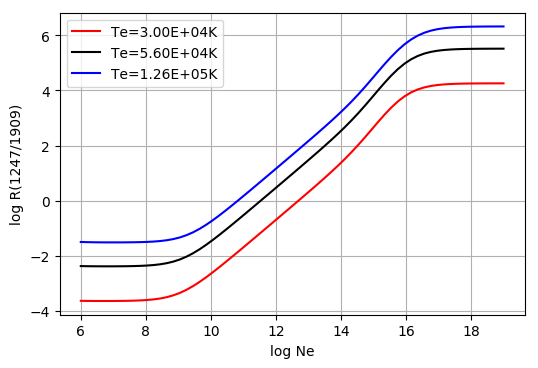

In [8]:
fmts = "-r", "-k", "-b"
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)
for k0 in range(nTe):
    ax.plot(np.log10(Ne), np.log10(ratio["1247/1909"][k0,:]), fmts[k0], label=f"Te={Te[k0]:1.2E}K")
ax.legend(loc="best")
ax.grid(True)
ax.set_ylabel("log R(1247/1909)", rotation=90)
ax.set_xlabel("log Ne")
#ax.set_xlim(8,13)
#ax.set_ylim(-4,1)
plt.show()

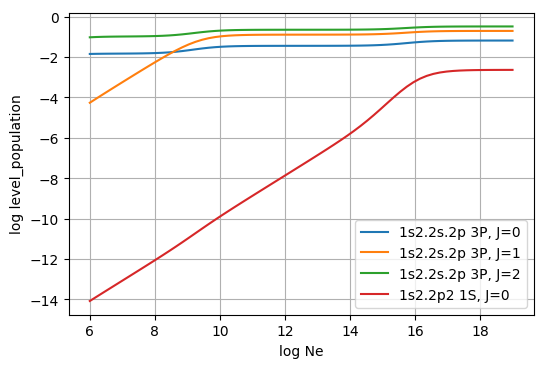

In [9]:
k0 = 1
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=100)
for j in (1,2,3,9):
    confs = atom.Level_info_table[j]
    ax.plot(np.log10(Ne), np.log10(n_SE[k0,:,j]), label=f"{confs[0]} {confs[1]}, J={confs[2]}")
ax.legend(loc="best")
ax.grid(True)
ax.set_ylabel("log level_population", rotation=90)
ax.set_xlabel("log Ne")
plt.show()